<p style="text-align:right;">Mario Stanke, University of Greifswald, Germany</p>

# Exercise Set 2, Solutions to Exercise 1 - Regression Neural Network

This is a copy of notebook ```nn-regr.ipynb``` for solving the following exercises:

  0. Run all cells.  
   
  1. Replace the sigmoid activation function with the **ReLU** function and observe how the shape of the predicted curve changes. *Revert back* afterwards to the *sigmoid* activation function.
   
  2. **Shift** the simulated data on the **x**-axis by **+50**.  
    
    2.1. **For the mathematically inclined:** Let $x' := x + 50$. Show or argue that it theoretically does not matter if you shift (use input $x'$) or not (use $x$):  *For any neural net $f(x)$ there is a neural net $f'(x')$ such that $f'(x') = f(x)$*. You may assume that $n=1$.
    
    2.2. Go to ADD YOUR CODE HERE and follow the instructions. Run all cells. What happens to the goodness of the fit? Do you have an explanation? Tip: Compute the net activations of the first layer manually right before training starts.

### **Answer to 2.1.:**
<img style="float:left" src="reparametrize.png" width="200px" />

Let $z_j$ be any particular net activation of the first hidden layer. We omit the superscripts that indicate the layers, here.

$$\begin{align*}
z_j &= \theta_{j,0} + \theta_{j,1} \cdot x\\
&=  \theta_{j,0} + \theta_{j,1} \cdot (x' - 50)\\
&= (\theta_{j,0} - 50 \cdot \theta_{j,1}) + \theta_{j,1} \cdot x'\\
&= \theta'_{j,0} + \theta_{j,1} \cdot x'
\end{align*}
$$

if one defines the bias term for the $j$-th unit of the first hidden layer of $f'$ as $\theta'_{j,0}:=\theta_{j,0} - 50 \cdot \theta_{j,1}$. Therefore, the activations of the first hidden layer are equal in the two networks and the remaining layers can be identical for the two networks to compute identical functions.

## Generate an Artificial Dataset

In [4]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense

tf.keras.backend.set_floatx('float64') # floating point precision 64 bits

In [5]:
def f(x):
    '''A simple one-dimensional function with a few extrema'''
    return np.sin(15 * x) + 9 * x - 9 * x**2

#### Simulate $(x, y)$ pairs as artificial data set

In [6]:
np.random.seed(1)
m = 100 # number of data points (examples)
x = np.linspace(0, 1, m) # equidistant in [0,1] (both boundaries included)
y_theoretical = f(x)     # the points on the curve
# ADD YOUR CODE HERE to shift x by +50, 1 line
x = x + 50
# YOUR CODE ENDS
sigma = 0.1
y = y_theoretical + sigma * np.random.randn(m) # observations have noise (normal with mean 0 and variance sigma^2 = 0.01)

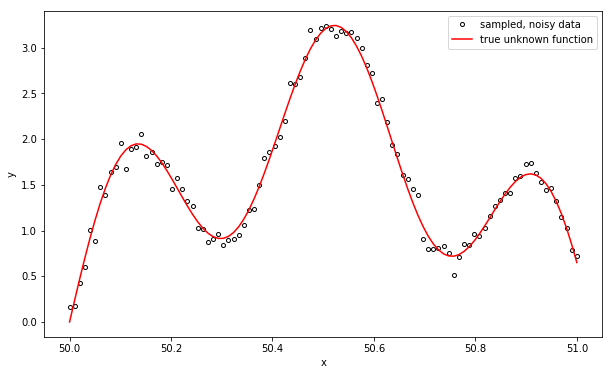

In [7]:
def plot_curve():
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.plot(x, y, 'ko', fillstyle = 'none', markersize = 4, label = "sampled, noisy data") # ko: blac(k) circle
    ax.plot(x, y_theoretical, 'r', label = "true unknown function")
    plt.xlabel("x")
    plt.ylabel("y")
    return ax

ax = plot_curve()
ax.legend();

## Create Neural Network Model  
We will use [```tf.keras```](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras), a high-level approach to neural network design and learning. The NN shall have 2 hidden layers with 8 neurons each. As activation functions we chose the logistic sigmoid function $\sigma$.

<img src="nn8-8.png" alt="network architecture" width="500"/>

In [8]:
np.random.seed(1) # so we all get the same pseudorandom results

# a neural network is a stack of layers, in keras called "Sequential" model
model = tf.keras.models.Sequential() # so far the stack is empty, 0 layers

# add neural network layers one by one
# Dense is a fully connected layer, parametrized by a matrix of shape (input_units, output_units).
# The first number given in Dense is the number of output units, the number of input units is implicit.
# By default use_bias=True which adds output_units parameters for each layer
# REPLACE THE ACTIVATION FUNCTION HERE with tf.nn.relu
model.add(Dense(8, activation = tf.nn.sigmoid, input_dim = 1)) # input dimension only required for first layer
model.add(Dense(8, activation = tf.nn.sigmoid))
# YOUR CHANGES END HERE
model.add(Dense(1))

model.summary()     # summarizes layers and parameters
Theta = model.get_weights() # a look under the 'hood' for teaching purposes
print(Theta)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
[array([[-0.81627233,  0.55105382,  0.17144903,  0.11361798,  0.30785604,
        -0.75850998,  0.50286005,  0.08587007]]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([[-0.53760224,  0.4732244 ,  0.09231696, -0.22511115,  0.20234576,
        -0.07377738,  0.18576471,  0.06654725],
       [ 0.53587425, -0.34334648,  0.18023019, -0.48357283, -0.04740218,
         0.30656741,  0.0801438

## Explanation, why the training with the x-shift by +50 fails
To see this we will manually compute the **activations of the first layer right after the random initialization** of the model parameters.

In [20]:
Theta0 = Theta[0] # weights of the first layer, shape =(1,8)
bias0 = Theta[1] # biases of the first layer, shape = (8,) 

# compute net activations of first layer
z1 = np.matmul(x.reshape([-1,1]), Theta0) + bias0


def sigmoid(z):
    """The logistic sigmoid function"""
    return 1 / (1 + np.exp(-z))

def sigmoid_deriv(x):
    """ The derivative of sigmoid"""
    return sigmoid(x) * (1-sigmoid(x))


print("z1\n", z1[0:5].round(3)) # print the net activations of the first layer for the first 5 examples
print("\na1\n", sigmoid(z1[0:5])) # print the net activations of the first layer for the first 10 examples
print("\nderivatives used in backprop:\n", sigmoid(z1[0:5])) # print the net activations of the first layer for the first 10 examples


z1
 [[-40.814  27.553   8.572   5.681  15.393 -37.925  25.143   4.294]
 [-40.822  27.558   8.574   5.682  15.396 -37.933  25.148   4.294]
 [-40.83   27.564   8.576   5.683  15.399 -37.941  25.153   4.295]
 [-40.838  27.569   8.578   5.684  15.402 -37.948  25.158   4.296]
 [-40.847  27.575   8.579   5.685  15.405 -37.956  25.163   4.297]]

a1
 [[1.88309224e-18 1.00000000e+00 9.99810788e-01 9.96601100e-01
  9.99999793e-01 3.38193347e-17 1.00000000e+00 9.86527009e-01]
 [1.86762965e-18 1.00000000e+00 9.99811115e-01 9.96604986e-01
  9.99999794e-01 3.35612106e-17 1.00000000e+00 9.86538533e-01]
 [1.85229402e-18 1.00000000e+00 9.99811442e-01 9.96608867e-01
  9.99999795e-01 3.33050566e-17 1.00000000e+00 9.86550047e-01]
 [1.83708433e-18 1.00000000e+00 9.99811768e-01 9.96612743e-01
  9.99999795e-01 3.30508578e-17 1.00000000e+00 9.86561551e-01]
 [1.82199952e-18 1.00000000e+00 9.99812094e-01 9.96616615e-01
  9.99999796e-01 3.27985990e-17 1.00000000e+00 9.86573046e-01]]

derivatives used in backprop

**Observation:** Almost all net activations of the first layer have a large absolute value. For large absolut value the logistic sigmoid function has a derivative very close to 0:

<img src="activ-sigma.png" alt="sigmoid function" width="300"/>

Therefore, any small change to any weight of an edge of the first layer that goes into such a unit is very close to 0 or even vanishes numerically.

### Compile the model

In [7]:
# define the loss, optimization algorithm and prepare the model for gradient computation 
opti = tf.keras.optimizers.Adam(learning_rate = 0.05) # Adam is a popular method for stochastic gradient descent
model.compile(optimizer = opti, loss = 'mse') # mean squared error

### Train the parameters (learning)

In [8]:
# execute the actual training 
history = model.fit(x, y, epochs=3000, verbose=0) # takes ~20s
# verbose = 1,2 gives more output

### Examine the learning progress

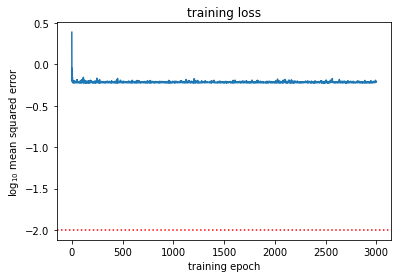

In [9]:
plt.plot(np.log10(history.history["loss"])); # one mse value per epoch
plt.title("training loss")
plt.xlabel("training epoch")
plt.ylabel(r"$\log_{10}$ mean squared error");
plt.axhline(y = np.log10(sigma**2), color = "red", linestyle = ":");

Observe that with our choice for the measurement noise the theoretical optimum for the mean squared error *on new data* is $10^{-2}$ (red dotted line).
### Use the model for predictions

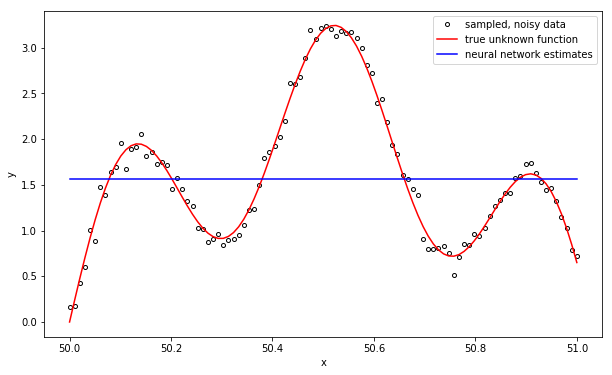

In [10]:
x_input = x.reshape((-1, 1)) # make x a matrix (with 1 column) as expected by predict
y_pred = model.predict(x_input)

ax = plot_curve()
ax.plot(x, y_pred, 'b', label = "neural network estimates") # (b)lue
ax.legend();